# Create WecOptTool Model for the Marson WEC concept

In [84]:
import autograd.numpy as np
import capytaine as cpt
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute
import pygmsh

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

import logging
logging.getLogger().setLevel(logging.INFO)

### Waves and Frequency array

In [85]:
wavefreq = 1/8 # Hz
f1 = wavefreq
nfreq = 10

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

amplitude = 0.0625 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

#### WEC geometry mesh
Now we will create a surface mesh for the WEC hull and store it using the `FloatingBody` object from Capytaine.

INFO:capytaine.io.meshio:Stored 2766 triangle faces as quadrilaterals


-0.15827988849250518


INFO:capytaine.io.meshio:Stored 2766 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_681"), lid_mesh=Mesh(..., name="lid for Rect"), dofs={}, center_of_mass=[-5.  0.  0.], name="rect0").
INFO:capytaine.bodies.bodies:Clipping rect0 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.bodies.bodies:Clipping rect0 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_681 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.bodies.bodies:New floating body: FloatingBody(mesh=CollectionOfMeshes(..., name="rect0_mesh"), lid_mesh=CollectionOfMeshes(..., name="rect0_lid_mesh"), dofs={"rect0__Pitc

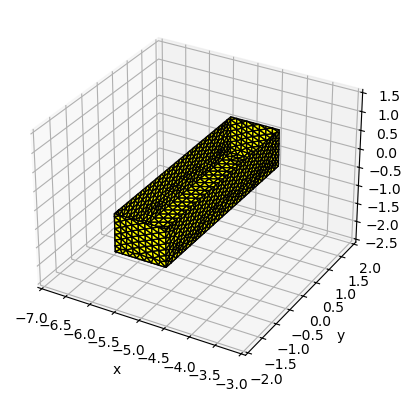

Axis(vector=[0. 1. 0.], point=[0. 0. 0.])


In [86]:
numBodies = 1
bodyDist = 10
bodyLocs = [-0.5*bodyDist, -1.5*bodyDist] #, 3]
mesh_size_factor = 0.16
depth = 2
bodDraft = [1, 1]#, 1]
bodWidth = [1, 1]#, 1]
bodLength = [2, 2]#, 2]

hydrostaticsDict = {}
rect = {}
bodList = []

for nBod in range(numBodies):
    with pygmsh.geo.Geometry() as geom:
        poly1 = geom.add_polygon(
            [[bodyLocs[nBod]-bodWidth[nBod]/2, bodLength[nBod]],
            [bodyLocs[nBod]-bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,bodLength[nBod]]],mesh_size=mesh_size_factor)
        
        geom.translate(poly1, [0, 0, depth-bodDraft[nBod]])
        geom.extrude(poly1,[0,0,-depth])
        rectMesh = geom.generate_mesh()
        meshObj = load_from_meshio(rectMesh, 'Rect')
        lid_pos = meshObj.lowest_lid_position(f1*nfreq*2*np.pi)
        print(lid_pos)
        #lid_pos = -.05
        lidMesh = meshObj.generate_lid(z=lid_pos)

        # define the floating body
        rect[nBod] = cpt.FloatingBody(mesh=rectMesh, lid_mesh = lidMesh, name="rect"+str(nBod), center_of_mass=(bodyLocs[nBod], 0, 0))
        rect[nBod].keep_immersed_part()

        rect[nBod].center_of_mass = (bodyLocs[nBod], 0, 0)
        rect[nBod].rotation_center = (-bodyDist*(nBod), 0, 0)

        #rect[nBod].add_translation_dof(name="Heave")

        axis = cpt.Axis(vector=(0, 1, 0), point=(-bodyDist*(nBod), 0, 0))
        rect[nBod].add_rotation_dof(axis=axis, name="Pitch")
        
        rect[nBod].inertia_matrix = rect[nBod].compute_rigid_body_inertia()
        rect[nBod].hydrostatic_stiffness = rect[nBod].immersed_part().compute_hydrostatic_stiffness()

        #print(rect[nBod].inertia_matrix)
        #print(rect[nBod].hydrostatic_stiffness)

        bodList.append(rect[nBod])

all_bodies = cpt.FloatingBody.join_bodies(*bodList)

#allBodies.show_matplotlib()
all_bodies.show_matplotlib()
ndof = all_bodies.nb_dofs

#all_bodies.show()
print(axis)

In [87]:
print(dir(all_bodies))
print(all_bodies.center_of_mass)
print(all_bodies.inertia_matrix)
print(all_bodies.hydrostatic_stiffness)
#all_bodies.show()

['__abstractmethods__', '__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rich_repr__', '__setattr__', '__short_str__', '__sizeof__', '__slotnames__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_infer_rotation_center', '_optional_params_str', '_repr_pretty_', 'add_all_rigid_body_dofs', 'add_dofs_labels_to_matrix', 'add_dofs_labels_to_vector', 'add_rotation_dof', 'add_translation_dof', 'animate', 'assemble_arbitrary_array', 'assemble_regular_array', 'center_of_buoyancy', 'center_of_mass', 'clip', 'clipped', 'cluster_bodies', 'combine_dofs', 'compute_hydrostatic_stiffness', 'compute_hydrostatics', 'compute_rigid_body_inertia', 'copy', 'disp_mass', 'dof_normals', 'dofs', 'each_hydrostatic_stiffness', 'extract_faces

#### Minimum wavelength check
With the frequency vector, wave environment, and geometry mesh all defined, we can now check to make sure they are all suitable to accurately simulate the WEC dynamics.
The `fb.minimal_computable_wavelength` method checks the mesh to determine the minimum wavelength that can be reliably computed using Capytaine.
We compare this value to the minimum wavelength our frequency vector will compute; we want this number to be <u>larger</u> than Capytaine's minimum wavelength.
A warning is printed if this is not the case.
This warning is ignored here because the BEM results have been validated, but can be used as a guide for mesh refinement to ensure accurate BEM results.

In [88]:
min_computable_wavelength = all_bodies.minimal_computable_wavelength
g = 9.81
min_period = 1/(f1*nfreq)
min_wavelength = (g*(min_period)**2)/(2*np.pi)

if min_wavelength < min_computable_wavelength:
    print(f'Warning: Minimum wavelength in frequency spectrum ({min_wavelength}) is smaller'
         f' than the minimum computable wavelength ({min_computable_wavelength}).')

In [89]:
bem_data = wot.run_bem(all_bodies, freq, wave_dirs=0)
# wot.write_netcdf('bem_data.nc', bem_data) # saves BEM data to file


INFO:capytaine.green_functions.delhommeau:Loading tabulation from C:\Users\jtgrasb\AppData\Local\capytaine\Cache\2.2\tabulation_float64_scaled_nemoh3_676_100.0_372_-251.0_1001.npz
INFO:capytaine.bodies.bodies:Clipping rect0_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_681 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.


[16:43:22] WARNING  Using the geometric centroid as the center of gravity (COG).

           WARNING  Using the center of gravity (COG) as the rotation center for hydrostatics.

The resolution of the mesh might be insufficient for omega ranging from 7.854 to 7.854.
This warning appears when the largest panel of this mesh has radius > wavelength/8.


           WARNING  Mesh resolution for 2 problems:                                                                
                    The resolution of the mesh might be insufficient for omega ranging from 7.854 to 7.854.        
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="rect0_immersed"), omega=0.785, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0_immersed"), omega=0.785, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="rect0_immersed"), omega=1.571, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0_immersed"), omega=1.571, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="rect0_immersed"), omega=2.356, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0_immersed"), omega=2.356, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO

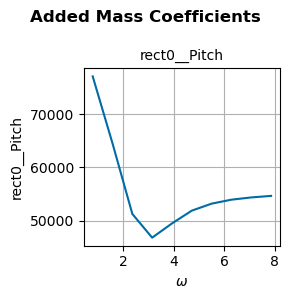

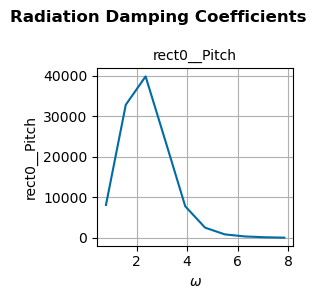

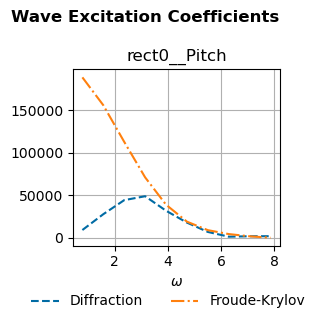

In [90]:
bem_data_plot = bem_data.sel(wave_direction = 0, method='nearest')
radiating_dofs = bem_data_plot.radiating_dof.values
influenced_dofs = bem_data_plot.influenced_dof.values

# plots
fig_am, ax_am = plt.subplots(
    len(radiating_dofs), 
    len(influenced_dofs),
    tight_layout=True, 
    sharex=True, 
    figsize=(3*len(radiating_dofs),3*len(influenced_dofs)),
    squeeze=False
    )
fig_rd, ax_rd = plt.subplots(
    len(radiating_dofs),
    len(influenced_dofs),
    tight_layout=True,
    sharex=True, 
    figsize=(3*len(radiating_dofs), 3*len(influenced_dofs)),
    squeeze=False
    )
fig_ex, ax_ex = plt.subplots(
    len(influenced_dofs),
    1,
    tight_layout=True, 
    sharex=True, 
    figsize=(3, 3*len(radiating_dofs)), 
    squeeze=False
    )
[ax.grid(True) for axs in (ax_am, ax_rd, ax_ex) for ax in axs.flatten()]
# plot titles
fig_am.suptitle('Added Mass Coefficients', fontweight='bold')
fig_rd.suptitle('Radiation Damping Coefficients', fontweight='bold')
fig_ex.suptitle('Wave Excitation Coefficients', fontweight='bold')

sp_idx = 0
for i, rdof in enumerate(radiating_dofs):
    for j, idof in enumerate(influenced_dofs):
        sp_idx += 1
        if i == 0:
            np.abs(bem_data_plot.diffraction_force.sel(influenced_dof=idof)).plot(
                ax=ax_ex[j,0], linestyle='dashed', label='Diffraction')
            np.abs(bem_data_plot.Froude_Krylov_force.sel(influenced_dof=idof)).plot(
                ax=ax_ex[j,0], linestyle='dashdot', label='Froude-Krylov')
            ex_handles, ex_labels = ax_ex[j,0].get_legend_handles_labels()
            ax_ex[j,0].set_title(f'{idof}')
            ax_ex[j,0].set_xlabel('')
            ax_ex[j,0].set_ylabel('')
        if j <= i:
            bem_data_plot.added_mass.sel(
                radiating_dof=rdof, influenced_dof=idof).plot(ax=ax_am[i, j])
            bem_data_plot.radiation_damping.sel(
                radiating_dof=rdof, influenced_dof=idof).plot(ax=ax_rd[i, j])
            if i == len(radiating_dofs)-1:
                ax_am[i, j].set_xlabel(f'$\omega$', fontsize=10)
                ax_rd[i, j].set_xlabel(f'$\omega$', fontsize=10)
                ax_ex[j, 0].set_xlabel(f'$\omega$', fontsize=10)
            else:
                ax_am[i, j].set_xlabel('')
                ax_rd[i, j].set_xlabel('')
            if j == 0:
                ax_am[i, j].set_ylabel(f'{rdof}', fontsize=10)
                ax_rd[i, j].set_ylabel(f'{rdof}', fontsize=10)
            else:
                ax_am[i, j].set_ylabel('')
                ax_rd[i, j].set_ylabel('')
            if j == i:
                ax_am[i, j].set_title(f'{idof}', fontsize=10)
                ax_rd[i, j].set_title(f'{idof}', fontsize=10)
            else:
                ax_am[i, j].set_title('')
                ax_rd[i, j].set_title('')
        else:
            fig_am.delaxes(ax_am[i, j])
            fig_rd.delaxes(ax_rd[i, j])
fig_ex.legend(ex_handles, ex_labels, loc=(0.08, 0), ncol=2, frameon=False)

In [91]:
print(abs(bem_data['Froude_Krylov_force']))

#print(bem_data['inertia_matrix'])

#print(bem_data['hydrostatic_stiffness'])

#print(bem_data['added_mass'])

print(bem_data['radiation_damping'])

<xarray.DataArray 'Froude_Krylov_force' (omega: 10, wave_direction: 1,
                                         influenced_dof: 1)> Size: 80B
array([[[1.88820956e+05]],

       [[1.56018490e+05]],

       [[1.12896666e+05]],

       [[7.10862816e+04]],

       [[3.88765625e+04]],

       [[1.89072417e+04]],

       [[8.89792109e+03]],

       [[4.28477786e+03]],

       [[1.66285094e+03]],

       [[1.70881615e+01]]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U14 56B 'rect0_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * wave_direction  (wave_direction) float64 8B 0.0
  * omega           (omega) float64 80B 0.7854 1.571 2.356 ... 6.283 7.069 7.854
  * influenced_dof  (influenced_dof) object 8B 'rect0__Pitch'
    period          (omega) float64 80B 8.0 4.0 2.667 2.0 ... 1.0 0.8889 0.8
Attributes:
    long_name:  Froude Krylov force
<xarray.DataArray 'radiation_damping' (omega: 10, ra

In [69]:
# place pto between body 1 and body 2 and power is based on relative motion
name = ["PTO_12",]
kinematics = np.array([[1]])
pto_ndof = 1
controller = None
loss = None
#pto_impedance = None

## PTO impedance definition
omega = bem_data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 0.0
drivetrain_friction = 0.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia +
                        drivetrain_friction +
                        1/(1j*omega)*drivetrain_stiffness)

winding_impedance = winding_resistance + 1j*omega*winding_inductance

pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

pto = wot.pto.PTO(pto_ndof, kinematics, controller, pto_impedance, loss, name)

In [70]:

# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec}

# Constraint
f_max = 20000
nsubsteps = 4

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())


constraints = [
    {'type': 'ineq', 'fun': const_f_pto},
]

wec = wot.WEC.from_bem(
    bem_data,
    constraints=constraints,
    friction=None,
    f_add=f_add,
)

print(dir(wec))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_constraints', '_derivative2_mat', '_derivative_mat', '_dof_names', '_forces', '_freq', '_inertia', '_inertia_in_forces', '_inertia_matrix', '_ndof', '_time', '_time_mat', 'constraints', 'decompose_state', 'derivative2_mat', 'derivative_mat', 'dof_names', 'dofmat_to_vec', 'dt', 'f1', 'fd_to_td', 'forces', 'frequency', 'from_bem', 'from_floating_body', 'from_impedance', 'inertia', 'inertia_in_forces', 'inertia_matrix', 'ncomponents', 'ndof', 'nfreq', 'nstate_wec', 'nt', 'omega', 'period', 'post_process', 'residual', 'solve', 'td_to_fd', 'tf', 'time', 'time_mat', 'time_mat_nsubsteps', 'time_nsubsteps', 'vec_to_dofmat', 'w1']


In [71]:
obj_fun = pto.mechanical_average_power
obj_fun = pto.average_power
nstate_opt = 2*nfreq

options = {'maxiter': 200}
scale_x_wec = 1e1
scale_x_opt = 1e-1
scale_obj = 1e0

results = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    )

opt_average_power = results[0].fun
print(f'Optimal average mechanical power: {opt_average_power} W')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.59e-02, 4.52e+01, 1.41e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.59e-02, 4.49e+01, 1.39e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.59e-02, 4.33e+01, 1.29e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.59e-02, 3.56e+01, 8.63e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.58e-02, 5.29e+00, -1.35e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.58e-02, 5.36e+00, -2.35e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.58e-02, 5.37e+00, -2.35e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.58e-02, 5.43e+00, -2.36e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.58e-02, 5.67e+00, -2.42e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.56e-02, 6.75e+00, -2.57e-01]
INFO:wecopttool.core:Sca

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.25853357870333005
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16
Optimal average mechanical power: -0.25853357870333005 W


In [72]:
def pto_location(wec, x_wec, x_opt, waves):
    pos_wec = wec.vec_to_dofmat(x_wec) # pitch angle of float

    x_pto = bodyDist*(1-np.cos(pos_wec))
    z_pto = -bodyDist*np.sin(pos_wec)
    theta_pto = pos_wec # pitch angle of pto equals pitch of float

    pto_location = np.stack((x_pto, z_pto, theta_pto), axis=1).squeeze()
    return pto_location


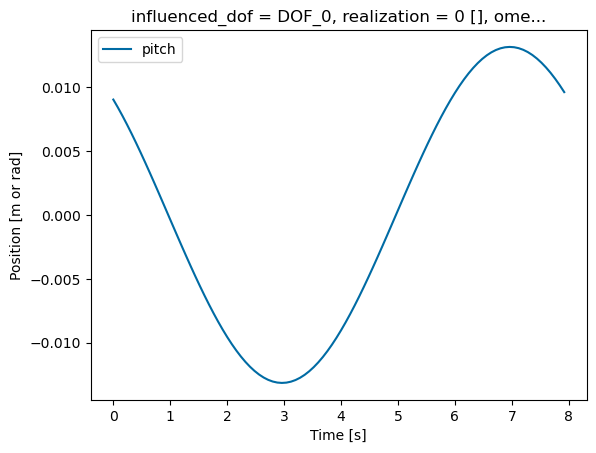

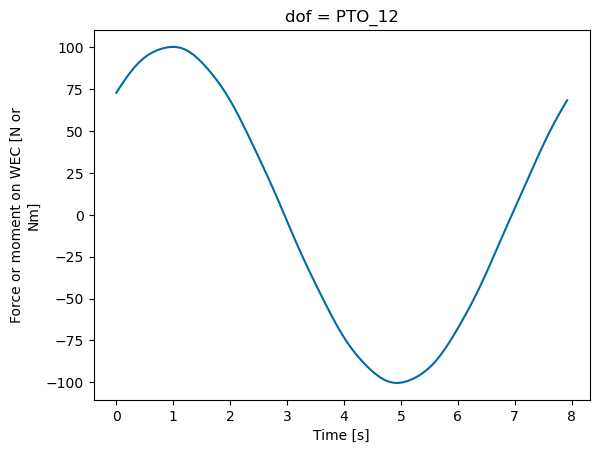

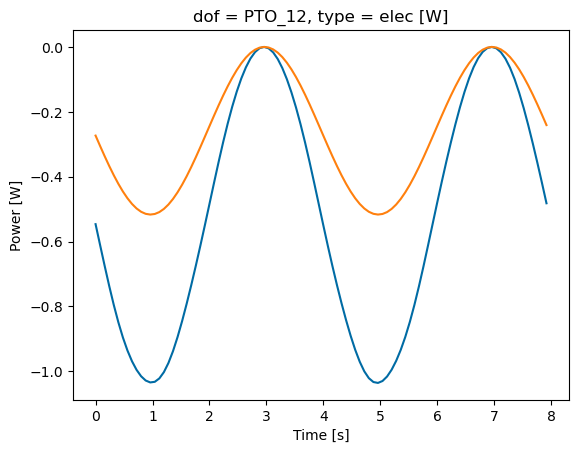

In [74]:
x_wec, x_opt = wec.decompose_state(results[0].x)

nsubsteps = 5
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)

plt.figure()
#wec_tdom[0]['pos'].plot(label='heave')
wec_tdom[0]['pos'].plot(label='pitch')
plt.legend()

plt.figure()
pto_tdom[0]['force'].plot()

plt.figure()
pto_tdom[0]['power'].loc['mech',:,:].plot()
pto_tdom[0]['power'].loc['elec',:,:].plot()


<xarray.DataArray 'type' (type: 6)> Size: 48B
array(['radiation', 'friction', 'hydrostatics', 'Froude_Krylov', 'diffraction',
       'PTO'], dtype=object)
Coordinates:
    realization  int32 4B 0
    omega        float64 8B 7.854
    freq         float64 8B 1.25
    period       float64 8B 0.8
  * type         (type) object 48B 'radiation' 'friction' ... 'PTO'
Attributes:
    long_name:  Type


Text(0, 0.5, 'hydrostatics')

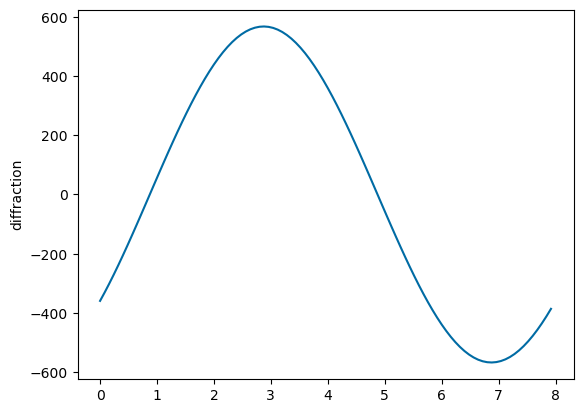

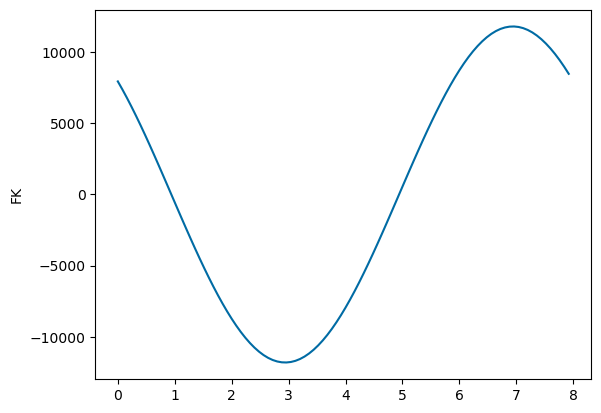

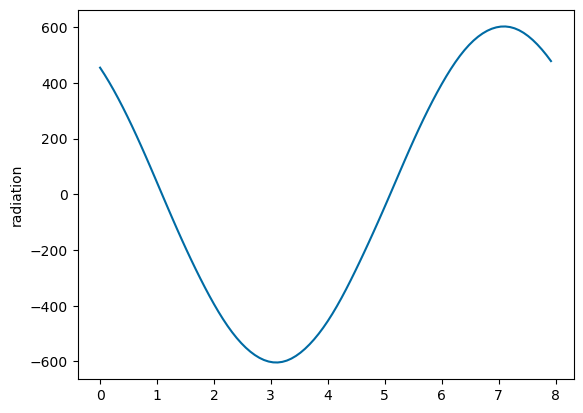

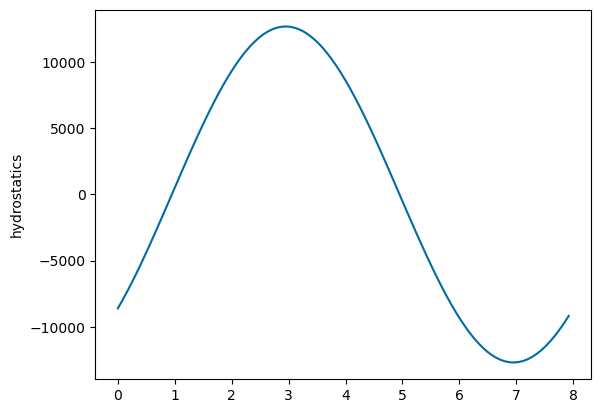

In [137]:
print(wec_tdom[0]['force']['type'])

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='diffraction')))
plt.ylabel('diffraction')


plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='Froude_Krylov')))
plt.ylabel('FK')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='radiation')))
plt.ylabel('radiation')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='hydrostatics')))
plt.ylabel('hydrostatics')